In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import lightgbm
import re

from scripts import fe_scripts as fe
from scripts import light
from sklearn.model_selection import train_test_split

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Feature Engineering on each dataset

## Prepare and store engineered datasets

In [2]:
# Bureau and bureau balance
df_bureau = fe.bureau_and_balance()
df_bureau.to_pickle('../data/data_outputs/feature_engineered/bureau.pkl')
df_bureau.shape

(305811, 79)

In [3]:
# Previous applications
df_previous = fe.previous_applications()
df_previous.to_pickle('../data/data_outputs/feature_engineered/previous.pkl')
df_previous.shape

(338857, 134)

In [4]:
# POS_CASH_balance
df_pos = fe.pos_cash()
df_pos.to_pickle('../data/data_outputs/feature_engineered/pos.pkl')
df_pos.shape

(337252, 18)

In [5]:
# Installments
df_install = fe.installments_payments()
df_install.to_pickle('../data/data_outputs/feature_engineered/installments.pkl')
df_install.shape

(339587, 22)

In [6]:
# Credit card balance
df_ccb = fe.credit_card_balance()
df_ccb.to_pickle('../data/data_outputs/feature_engineered/credit_card.pkl')
df_ccb.shape

(103558, 113)

## Merging all dataframes

In [7]:
# Main dataset
df_app = pd.read_pickle('../data/data_outputs/feature_engineered/application.pkl')
#df_app = df_app[~df_app['TARGET'].isna()]
df_app.shape

(356251, 184)

In [8]:
# Merge bureau
df_ = df_app.join(df_bureau, how = 'left', on = 'SK_ID_CURR')

del df_app
del df_bureau
gc.collect()

4

In [9]:
# Merge Previous applications
df_ = df_.join(df_previous, how = 'left', on = 'SK_ID_CURR')
del df_previous
gc.collect()

0

In [10]:
# Merge POS_CASH_balance
df_ = df_.join(df_pos, how = 'left', on = 'SK_ID_CURR')
del df_pos
gc.collect()

0

In [11]:
# Merge installments
df_ = df_.join(df_install, how = 'left', on = 'SK_ID_CURR')
del df_install
gc.collect()

0

In [12]:
# Merge Credit card balance
df_ = df_.join(df_ccb, how = 'left', on = 'SK_ID_CURR')
del df_ccb
gc.collect()

0

In [13]:
df_.shape

(356251, 550)

## Storing datasets

In [14]:
df_[~df_['TARGET'].isna()].to_pickle('../data/data_outputs/feature_engineered/full_dataset_train.pkl')
df_[df_['TARGET'].isna()].to_pickle('../data/data_outputs/feature_engineered/full_dataset_test.pkl')

del df_
gc.collect()

44

# Feature Selection

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection/notebook

A chaque étape, évaluer l'impact sur les perfs pour ne pas supprimer de features déterminantes, voir faire varier le seuil (R²max / % NaN)

In [15]:
# Loading dataset
data = pd.read_pickle('../data/data_outputs/feature_engineered/full_dataset_train.pkl')
data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace = True)

In [16]:
# Baseline performance before feature selection
light.kfold_lightgbm(data.iloc[:10000], num_folds=5, stratified = True)

Starting LightGBM. Train shape: (10000, 550), test shape: (0, 550)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.972319	training's binary_logloss: 0.153493	valid_1's auc: 0.77953	valid_1's binary_logloss: 0.235573
[200]	training's auc: 0.997858	training's binary_logloss: 0.103941	valid_1's auc: 0.781187	valid_1's binary_logloss: 0.234532
[300]	training's auc: 0.999871	training's binary_logloss: 0.0753044	valid_1's auc: 0.775403	valid_1's binary_logloss: 0.238193
Early stopping, best iteration is:
[127]	training's auc: 0.985838	training's binary_logloss: 0.13677	valid_1's auc: 0.782254	valid_1's binary_logloss: 0.233938
Fold  1 AUC : 0.782254
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.975841	training's binary_logloss: 0.152654	valid_1's auc: 0.766123	valid_1's binary_logloss: 0.236139
[200]	training's auc: 0.997472	training's binary_logloss: 0.104334	valid_1's auc: 0.778058	valid_1's binary_logloss: 0.233

## Searching and dropping columns high correlations

In [17]:
# Correlation matrix
corr = data.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

In [18]:
# Number and proportion of columns with high correlations 
l_drop = [c for c in upper.columns if any(upper[c]>0.9)]
len(l_drop), len(l_drop)/len(upper)

(149, 0.27090909090909093)

In [19]:
# Performance impact if dropping high correlations
light.kfold_lightgbm(data.iloc[:10000].drop(columns = l_drop), num_folds=5, stratified = True)

Starting LightGBM. Train shape: (10000, 401), test shape: (0, 401)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.973038	training's binary_logloss: 0.155478	valid_1's auc: 0.779764	valid_1's binary_logloss: 0.235497
[200]	training's auc: 0.998409	training's binary_logloss: 0.105343	valid_1's auc: 0.784719	valid_1's binary_logloss: 0.232305
[300]	training's auc: 0.999907	training's binary_logloss: 0.0765227	valid_1's auc: 0.782247	valid_1's binary_logloss: 0.235132
[400]	training's auc: 0.999997	training's binary_logloss: 0.0573394	valid_1's auc: 0.778376	valid_1's binary_logloss: 0.241482
Early stopping, best iteration is:
[201]	training's auc: 0.998445	training's binary_logloss: 0.104989	valid_1's auc: 0.784635	valid_1's binary_logloss: 0.232287
Fold  1 AUC : 0.784635
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.977525	training's binary_logloss: 0.154282	valid_1's auc: 0.79058	valid_1's binary_logloss: 0.2

In [20]:
# Delete columns highly correlated with another column
data = data.drop(columns = l_drop)

In [21]:
del corr, upper

## Handling missing values

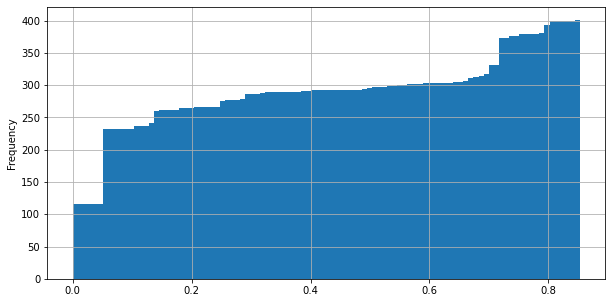

In [22]:
# Proportion of missing values
s_ = data.isnull().sum()/len(data)
s_.plot(kind = 'hist', bins = 100, figsize = (10,5), cumulative = True)
plt.grid()
plt.show()

In [23]:
# Number and proportion of columns high percentage of missing values
len(s_[s_>0.75]), len(s_[s_>0.75])/len(s_)

(25, 0.06234413965087282)

In [24]:
# Performance impact if dropping high percentage of missing values
l_drop = [x for x in s_[s_>0.75].index]
light.kfold_lightgbm(data.iloc[:10000].drop(columns = l_drop), num_folds=5, stratified = True)

Starting LightGBM. Train shape: (10000, 376), test shape: (0, 376)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.972528	training's binary_logloss: 0.155331	valid_1's auc: 0.7796	valid_1's binary_logloss: 0.23484
[200]	training's auc: 0.998415	training's binary_logloss: 0.10531	valid_1's auc: 0.788632	valid_1's binary_logloss: 0.230798
[300]	training's auc: 0.999911	training's binary_logloss: 0.0765618	valid_1's auc: 0.784593	valid_1's binary_logloss: 0.234424
[400]	training's auc: 0.999994	training's binary_logloss: 0.0574838	valid_1's auc: 0.783593	valid_1's binary_logloss: 0.239012
Early stopping, best iteration is:
[203]	training's auc: 0.998512	training's binary_logloss: 0.104245	valid_1's auc: 0.789111	valid_1's binary_logloss: 0.230669
Fold  1 AUC : 0.789111
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.977572	training's binary_logloss: 0.154322	valid_1's auc: 0.785051	valid_1's binary_logloss: 0.2361

In [25]:
# Performance impact if dropping high percentage of missing values
l_drop = [x for x in s_[s_>0.80].index]
light.kfold_lightgbm(data.iloc[:10000].drop(columns = l_drop), num_folds=5, stratified = True)

Starting LightGBM. Train shape: (10000, 380), test shape: (0, 380)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.973021	training's binary_logloss: 0.155699	valid_1's auc: 0.779407	valid_1's binary_logloss: 0.234378
[200]	training's auc: 0.998337	training's binary_logloss: 0.10605	valid_1's auc: 0.785352	valid_1's binary_logloss: 0.231461
[300]	training's auc: 0.999894	training's binary_logloss: 0.0773393	valid_1's auc: 0.784618	valid_1's binary_logloss: 0.233625
Early stopping, best iteration is:
[186]	training's auc: 0.997601	training's binary_logloss: 0.1112	valid_1's auc: 0.785953	valid_1's binary_logloss: 0.231157
Fold  1 AUC : 0.785953
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.978038	training's binary_logloss: 0.154231	valid_1's auc: 0.783313	valid_1's binary_logloss: 0.236956
[200]	training's auc: 0.997827	training's binary_logloss: 0.105781	valid_1's auc: 0.789824	valid_1's binary_logloss: 0.2325

In [26]:
# Dropping columns where more than 80% of values are missing
data = data.drop(columns = l_drop)
data.shape

del s_, l_drop

## Feature importance

In [27]:
data_sample = data.sample(50000).drop(columns = ['SK_ID_CURR'])
X_ = data_sample.drop(columns = ['TARGET']).values
y_ = data_sample['TARGET'].values

feature_importances = np.zeros(X_.shape[1])

# LightGBM model
model = lightgbm.LGBMClassifier(objective='binary', 
                                boosting_type = 'goss', 
                                n_estimators = 1000, 
                                class_weight = 'balanced')

# Train the model several times and retrieve mean feature importances
for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.35, random_state = i)
    model.fit(x_train, y_train, 
              early_stopping_rounds = 100, 
              eval_set = [(x_test, y_test)],
              eval_metric = 'auc',
              verbose = 200
             )
    feature_importances += abs(model.feature_importances_)
    
# Mean of feature_importances
feature_importances = feature_importances/2

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's auc: 0.764998	valid_0's binary_logloss: 0.474381
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.755109	valid_0's binary_logloss: 0.448934


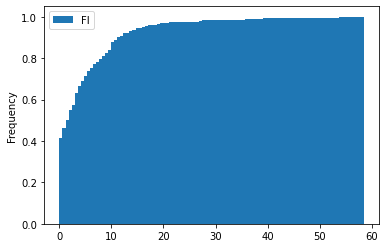

In [28]:
# Feature importance per feature
df_fi = pd.DataFrame(feature_importances,index = data_sample.drop(columns = ['TARGET']).columns, columns = ['FI'])
df_fi.plot(kind = 'hist', cumulative = True, density = True, bins = 100)
plt.show()

In [29]:
# Features with a null importance
l_drop = list(df_fi[df_fi['FI']==0].index)
len(l_drop), len(l_drop)/data.shape[1]

(128, 0.3368421052631579)

In [30]:
# Impact on dropping features with zero importance
light.kfold_lightgbm(data.iloc[:10000].drop(columns = l_drop), num_folds=5, stratified = True)

Starting LightGBM. Train shape: (10000, 252), test shape: (0, 252)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.972669	training's binary_logloss: 0.155252	valid_1's auc: 0.779379	valid_1's binary_logloss: 0.235429
[200]	training's auc: 0.998339	training's binary_logloss: 0.105167	valid_1's auc: 0.784488	valid_1's binary_logloss: 0.231946
[300]	training's auc: 0.999897	training's binary_logloss: 0.076585	valid_1's auc: 0.784583	valid_1's binary_logloss: 0.234296
Early stopping, best iteration is:
[164]	training's auc: 0.995119	training's binary_logloss: 0.119821	valid_1's auc: 0.78524	valid_1's binary_logloss: 0.231642
Fold  1 AUC : 0.785240
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.976946	training's binary_logloss: 0.154238	valid_1's auc: 0.781813	valid_1's binary_logloss: 0.237605
[200]	training's auc: 0.997942	training's binary_logloss: 0.105978	valid_1's auc: 0.782719	valid_1's binary_logloss: 0.234

In [31]:
del data_sample, X_, y_, x_train, x_test, y_train, y_test

# Storing cleaned datasets

In [32]:
# Storing cleaned training set
data.to_pickle('../data/data_outputs/feature_engineered/cleaned_dataset_train.pkl')
l_columns = data.columns.tolist()
del data
gc.collect()

44

In [47]:
# Storing cleaned test set
data_test = pd.read_pickle('../data/data_outputs/feature_engineered/full_dataset_test.pkl')
data_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x), inplace = True)
data_test = data_test[l_columns]

data_test.to_pickle('../data/data_outputs/feature_engineered/cleaned_dataset_test.pkl')
del data_test
gc.collect()

8